In [1]:
import os
import pandas as pd
import numpy as np
import scipy.sparse as sp
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from textvec import vectorizers
from sklearn.datasets import fetch_20newsgroups
import itertools
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline
RS = 13

In [2]:
def get_binary_RT_data():
    texts = []
    y = []
    f_path = f'./data/rottendata/rt-polarity.pos'
    with open(f_path, encoding = "ISO-8859-1") as f:
        for text in f:
            texts.append(text)
            y.append(1)
    f_path = f'./data/rottendata/rt-polarity.neg'
    with open(f_path, encoding = "ISO-8859-1") as f:
        for text in f:
            texts.append(text)
            y.append(0)
    X_train, X_test, y_train, y_test = train_test_split(texts, y, stratify=y, test_size=0.2, random_state=RS)
    train_data = pd.DataFrame({'text': X_train, 'y': y_train})#.sample(400)
    test_data = pd.DataFrame({'text': X_test, 'y': y_test})#.sample(400)
    return train_data, test_data

In [3]:
def get_binary_imdb_data():
    def get_df(corpus_type):
        texts = []
        y = []
        base_dir = './data/aclImdb_v1/aclImdb/'
        corpus_type_dir = os.path.join(base_dir, f'{corpus_type}/pos/')
        for f_name in os.listdir(corpus_type_dir):
            f_path = os.path.join(corpus_type_dir, f_name)
            with open(f_path) as f:
                texts.append(f.read())
                y.append(1)
        corpus_type_dir = os.path.join(base_dir, f'{corpus_type}/neg/')
        for f_name in os.listdir(corpus_type_dir):
            f_path = os.path.join(corpus_type_dir, f_name)
            with open(f_path) as f:
                texts.append(f.read())
                y.append(0)
        df = pd.DataFrame()
        df['y'] = y
        df['text'] = texts
        return df
    train_data = get_df('train')
    test_data = get_df('test')
    return train_data, test_data

In [17]:
def airline_binary_sentiment_data():
    df = pd.read_csv('./data/airline-sentiment/Airline-Sentiment-2-w-AA.csv',encoding = "ISO-8859-1")
    df = df[df.airline_sentiment.isin(['negative','positive'])]
    df.loc[df.airline_sentiment == 'negative','airline_sentiment'] = 0
    df.loc[df.airline_sentiment == 'positive','airline_sentiment'] = 1
    X_train, X_test, y_train, y_test = train_test_split(df.text, df.airline_sentiment, stratify=df.airline_sentiment, test_size=0.2, random_state=13)
    train_data = pd.DataFrame({'text': X_train, 'y': y_train})
    test_data = pd.DataFrame({'text': X_test, 'y': y_test})
    return train_data, test_data

In [4]:
imdb_train_data, imdb_test_data = get_binary_imdb_data()

In [5]:
rt_train_data, rt_test_data = get_binary_RT_data()

In [18]:
airbin_train_data, airbin_test_data = airline_binary_sentiment_data()

In [6]:
def count_score(baseVectorizer, freqVectorizer, model, train_data, test_data, with_prob=False, supervised=True):
    baseVectorizer.fit(train_data.text)
    if supervised:
        freqVectorizer.fit(baseVectorizer.transform(train_data.text), train_data.y)
    else:
        freqVectorizer.fit(baseVectorizer.transform(train_data.text))
    freq_train = freqVectorizer.transform(baseVectorizer.transform(train_data.text))
    freq_test = freqVectorizer.transform(baseVectorizer.transform(test_data.text))
    model.fit(freq_train, train_data.y)
    if with_prob:
        preds = model.predict_proba(freq_test)
    else:
        preds = model.predict(freq_test)
    return preds

In [7]:
def get_test_cases(train_data, test_data):
    return {
        'tf': {"baseVectorizer":CountVectorizer(ngram_range=(1,2)),
                 "freqVectorizer":TfidfTransformer(sublinear_tf=True, use_idf=False),
                 "model":LogisticRegression(),
                 "train_data":train_data,
                 "test_data":test_data,
                 "with_prob":False,
                 "supervised":False
                },
        'tfidf': {"baseVectorizer":CountVectorizer(ngram_range=(1,2)),
                 "freqVectorizer":TfidfTransformer(sublinear_tf=True),
                 "model":LogisticRegression(),
                 "train_data":train_data,
                 "test_data":test_data,
                 "with_prob":False,
                 "supervised":False
                },
        'tfpf': {"baseVectorizer":CountVectorizer(ngram_range=(1,2)),
             "freqVectorizer":vectorizers.TfpfVectorizer(sublinear_tf=True, norm=False),
             "model":LogisticRegression(),
             "train_data":train_data,
             "test_data":test_data,
             "with_prob":False,
             "supervised":True
            },
        'tfrf': {"baseVectorizer":CountVectorizer(ngram_range=(1,2)),
             "freqVectorizer":vectorizers.TfrfVectorizer(sublinear_tf=True, norm=False),
             "model":LogisticRegression(),
             "train_data":train_data,
             "test_data":test_data,
             "with_prob":False,
             "supervised":True
            },
        'tficf': {"baseVectorizer":CountVectorizer(ngram_range=(1,2)),
             "freqVectorizer":vectorizers.TfIcfVectorizer(sublinear_tf=True, norm=False),
             "model":LogisticRegression(),
             "train_data":train_data,
             "test_data":test_data,
             "with_prob":False,
             "supervised":True
            },
        'tfbinicf': {"baseVectorizer":CountVectorizer(ngram_range=(1,2)),
             "freqVectorizer":vectorizers.TfBinIcfVectorizer(sublinear_tf=True, norm=False),
             "model":LogisticRegression(),
             "train_data":train_data,
             "test_data":test_data,
             "with_prob":False,
             "supervised":True
            },
        'tfchi2': {"baseVectorizer":CountVectorizer(ngram_range=(1,2)),
             "freqVectorizer":vectorizers.Tfchi2Vectorizer(sublinear_tf=True),
             "model":LogisticRegression(),
             "train_data":train_data,
             "test_data":test_data,
             "with_prob":False,
             "supervised":True
            },
        'tfgr': {"baseVectorizer":CountVectorizer(ngram_range=(1,2)),
             "freqVectorizer":vectorizers.TfgrVectorizer(sublinear_tf=True),
             "model":LogisticRegression(),
             "train_data":train_data,
             "test_data":test_data,
             "with_prob":False,
             "supervised":True
            },
        'tfir': {"baseVectorizer":CountVectorizer(ngram_range=(1,2)),
             "freqVectorizer":vectorizers.TfirfVectorizer(sublinear_tf=True),
             "model":LogisticRegression(),
             "train_data":train_data,
             "test_data":test_data,
             "with_prob":False,
             "supervised":True
            },
        'tfor': {"baseVectorizer":CountVectorizer(ngram_range=(1,2)),
             "freqVectorizer":vectorizers.TforVectorizer(sublinear_tf=True, norm=False),
             "model":LogisticRegression(),
             "train_data":train_data,
             "test_data":test_data,
             "with_prob":False,
             "supervised":True
            }
    }

In [8]:
def test_data(train_data, test_data, test_name = ''):
    cases = get_test_cases(train_data,test_data)
    for k, v in cases.items():
        cases[k].update({'preds': count_score(**v)})
        cases[k].update({'accuracy': accuracy_score(v['test_data'].y, v['preds'])})
    results = []
    for k, v in cases.items():
        results.append((k, v['accuracy'],v['preds']))
    results = sorted(results, key= lambda x:x[1], reverse=True)
    corrs = np.corrcoef(list(zip(*results))[2])
    accs = list(zip(*results))[1]
    labels = [f'{x}:{accs[i]:.4f}' for i, x in enumerate(list(zip(*results))[0])]
    fig, ax = plt.subplots(figsize=(10,10)) 
    ax = sns.heatmap(corrs, 
                     linewidth=0.5, 
                     annot=corrs, 
                     square=True, 
                     ax=ax, 
                     xticklabels=labels,
                     yticklabels=labels)
    ax.set_title(test_name)
    plt.show()

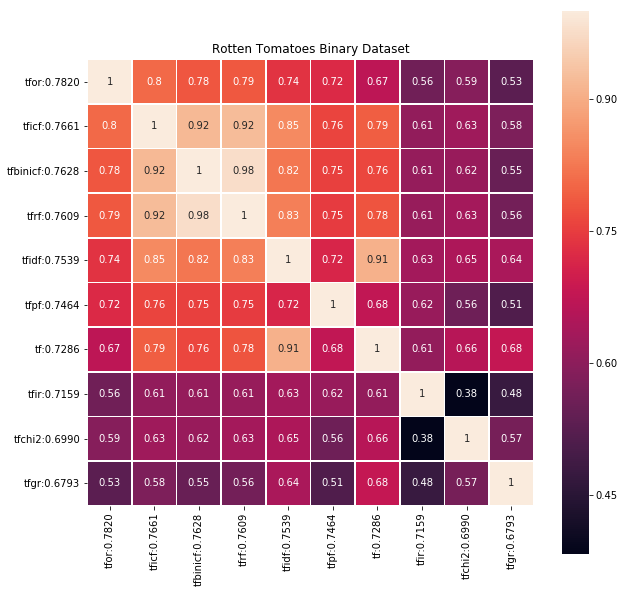

In [9]:
test_data(rt_train_data, rt_test_data, 'Rotten Tomatoes Binary Dataset')

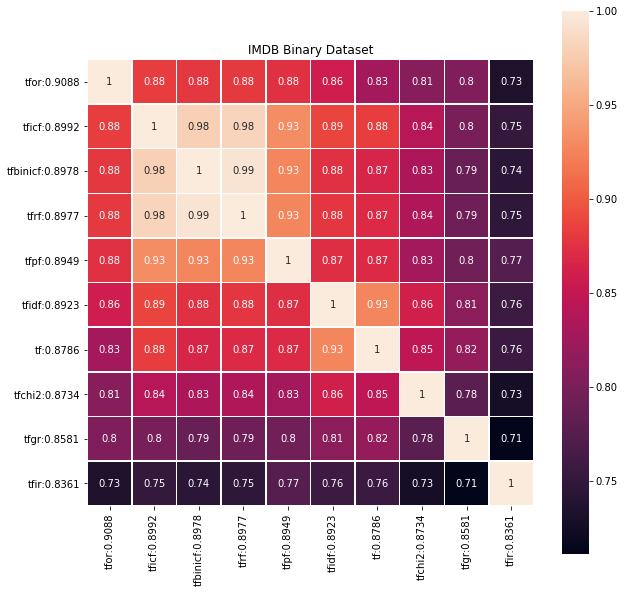

In [10]:
test_data(imdb_train_data, imdb_test_data, 'IMDB Binary Sentiment Dataset')

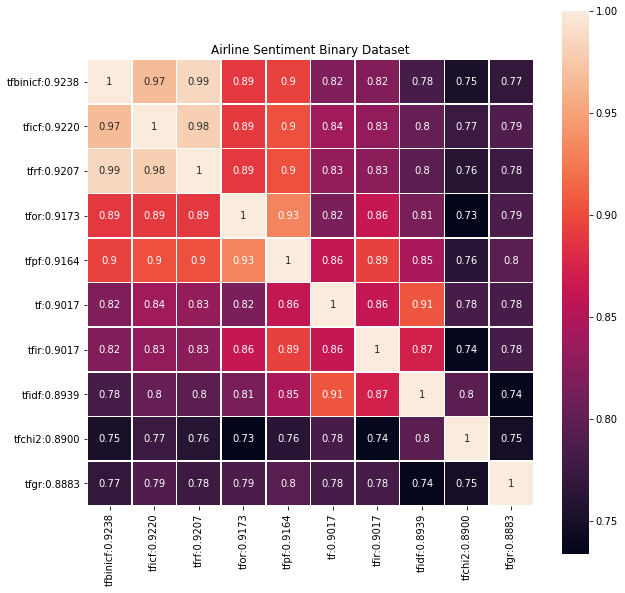

In [19]:
test_data(airbin_train_data, airbin_test_data, 'Airline Sentiment Binary Dataset')